<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Time_series/Arima/AirPassengersTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Air Passengers Time Series

## Import libs

In [59]:
%%capture
!pip install xgboost

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import xgboost as xgb

from pandas.tseries.offsets import DateOffset
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf

In [2]:
%matplotlib inline

## Download dataset

In [3]:
%%capture
! wget https://raw.githubusercontent.com/Dimildizio/DS_course/main/Time_series/Arima/AirPassengers.csv

## First view of data

In [4]:
data = pd.read_csv('AirPassengers.csv')

In [5]:
data.columns

Index(['Month', '#Passengers'], dtype='object')

In [6]:
data.shape

(144, 2)

In [7]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
#Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


<Axes: >

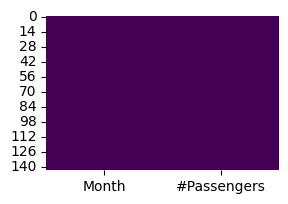

In [10]:
plt.figure(figsize=(3,2))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')

## Perform some transformations

In [11]:
df = data.copy()
df.index = pd.to_datetime(df['Month'])
#df.set_index('Month', inplace=True)
df.drop(['Month'], axis=1, inplace=True)
df = df.rename(columns={'#Passengers':'Passengers'})
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [12]:
monthmin = df.index.min()
monthmax = df.index.max()
display(monthmin)
display(monthmax)

Timestamp('1949-01-01 00:00:00')

Timestamp('1960-12-01 00:00:00')

In [13]:
df.resample('M').sum().tail()

,Passengers
Month,
1960-08-31,606
1960-09-30,508
1960-10-31,461
1960-11-30,390
1960-12-31,432


Emm we don't really need to explicitly set freq=M as of now.
Don't really want to convert 1960-12-01 to 1960-12-31 since we don't know the day colud be the last could be the first. After all we converted form YYYY-MM string format.
Anyways there should be any values but 1 for days.

In [14]:
any(timestamp.day != 1 for timestamp in df.index)

False

### Plot the time series

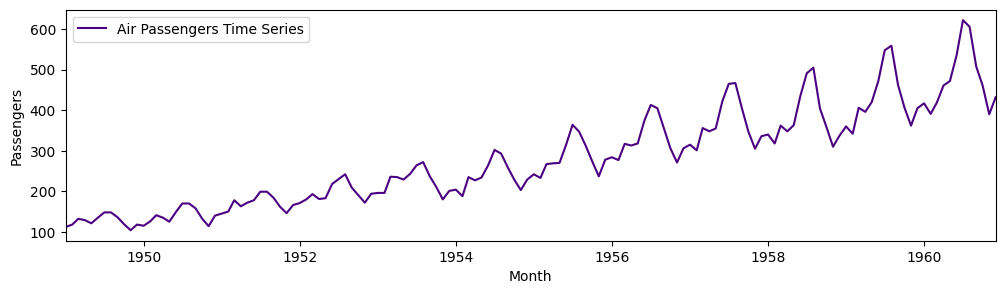

In [15]:
plt.figure(figsize=(12,3))
sns.lineplot(data=df, x=df.index, y='Passengers', label='Air Passengers Time Series', color='indigo')
plt.xlim(df.index.min(), df.index.max())
plt.show()

Peaks grow *higher* and *wider* thus we got **multiplicative** model

### Get rolling mean and std

In [16]:
rolling = df.rolling(window=12)
pd.concat([rolling.mean(), rolling.std()], keys= ['mean', 'std'], axis=1)

,mean,std
,Passengers,Passengers
Month,,
1949-01-01,NaN,NaN
1949-02-01,NaN,NaN
1949-03-01,NaN,NaN
1949-04-01,NaN,NaN
1949-05-01,NaN,NaN
...,...,...
1960-08-01,463.333333,83.630500
1960-09-01,467.083333,84.617276


## Check stationarity

### Moving average and rolling std

In [17]:
def get_ma_std(df):
  rolling = df.rolling(window=12)
  plt.figure(figsize=(10,3))
  sns.lineplot(data=df, x=df.index, y='Passengers', label='Data', color='indigo')
  sns.lineplot(rolling.mean()['Passengers'], label='mean', color='red')
  sns.lineplot(rolling.std()['Passengers'], label='std', color='magenta')
  plt.show()

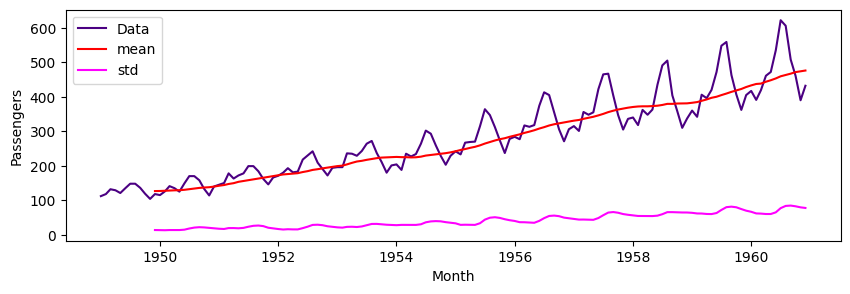

In [18]:
get_ma_std(df)

### Dickey-Fuller test for stationarity

In [19]:
def test_stationarity(df):
  get_ma_std(df)
  fuller = adfuller(df, autolag='AIC')
  fuller_result = pd.Series(fuller[:4], index = ['Statistics', 'p-value', 'Lags', 'Observations num'])
  for key, value in fuller[4].items():
    fuller_result[f'Critical value {key}'] = value
  return pd.DataFrame(fuller_result, columns = ['result']).apply(lambda x: round(x, 3))

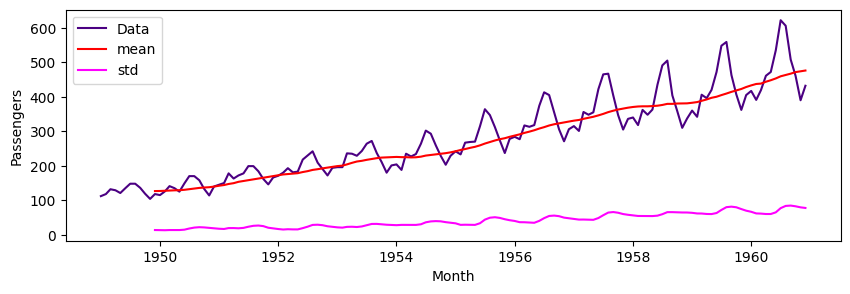

,result
Statistics,0.815
p-value,0.992
Lags,13.000
Observations num,130.000
Critical value 1%,-3.482
Critical value 5%,-2.884
Critical value 10%,-2.579


In [20]:
test_stationarity(df)

p-value 0.992 means the data is most probably(99% duh) non-stationary.
ADF statistics 0.815 is far away from the absolute Critical values thus we cannot reject the null-hypothesis that the data is stationary.
Ergo, data is **not stationary**.

## Decompose

In [21]:
decomp = sm.tsa.seasonal_decompose(df['Passengers'], model='multiplicative', period=12)

### Trend

<Axes: xlabel='Month'>

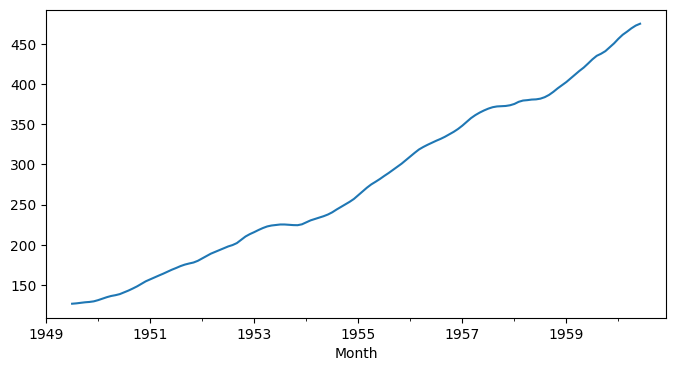

In [22]:
plt.figure(figsize=(8,4))
decomp.trend.plot()

Clearly **upward** trend

### Seasonal

<Axes: xlabel='Month'>

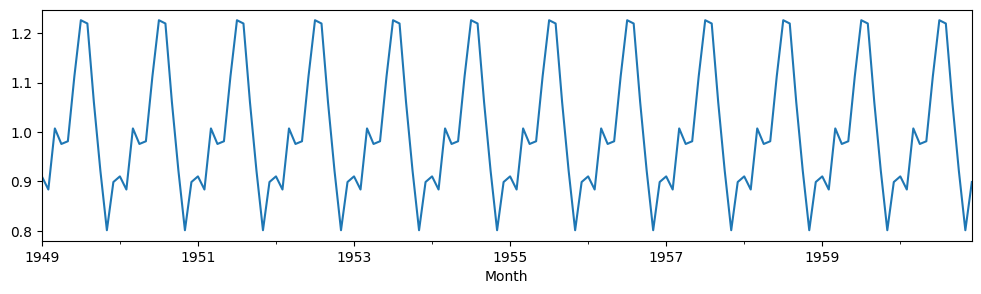

In [23]:
plt.figure(figsize=(12, 3))
decomp.seasonal.plot()

**One-year** seasonality

### Residuals

<Axes: xlabel='Month'>

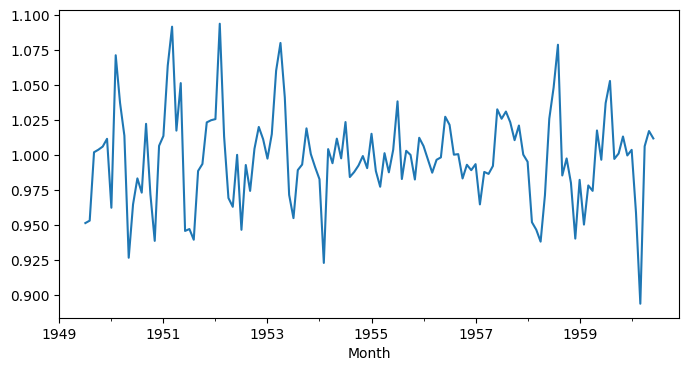

In [24]:
plt.figure(figsize=(8,4))
decomp.resid.plot()

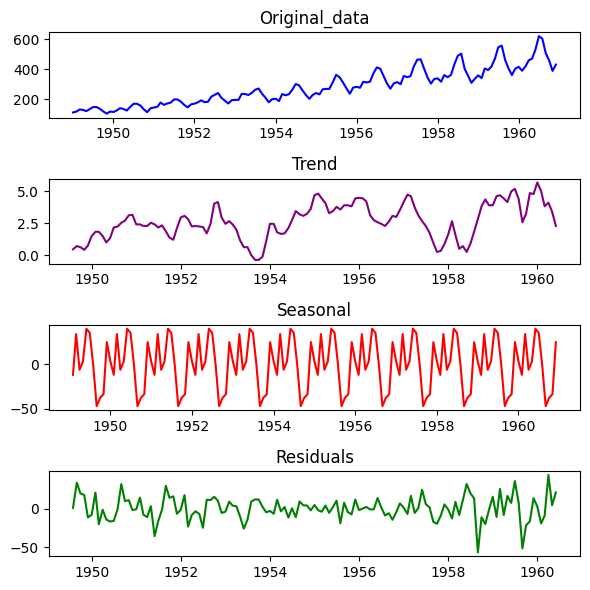

In [25]:
df_diff = df.diff().dropna()
diff_dec = sm.tsa.seasonal_decompose(df_diff, period=12)
fig, axes = plt.subplots(4, 1, figsize=(6, 6))

axes[0].plot(df.index, df['Passengers'], color='blue')
axes[0].set_title('Original_data')
axes[1].plot(diff_dec.trend, color='purple')
axes[1].set_title('Trend')
axes[2].plot(diff_dec.seasonal, color='red')
axes[2].set_title('Seasonal')
axes[3].plot(diff_dec.resid, color='green')
axes[3].set_title('Residuals')
plt.tight_layout()

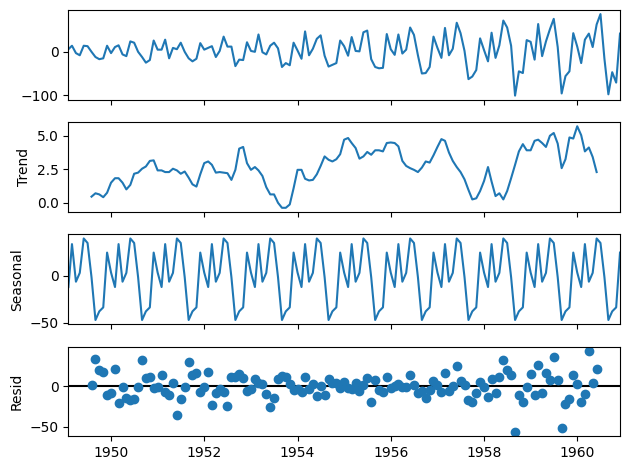

In [26]:
decplot = diff_dec.plot()
decplot.show()

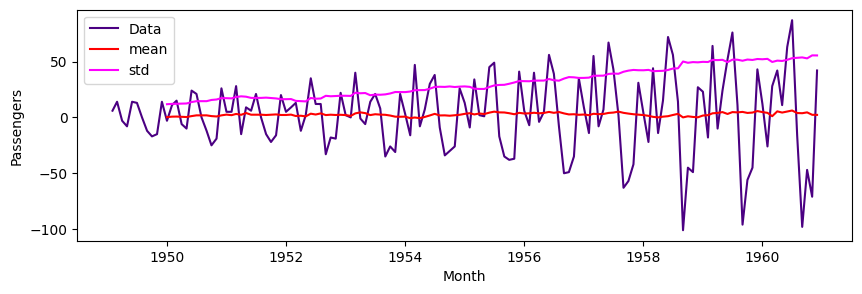

,result
Statistics,-2.829
p-value,0.054
Lags,12.000
Observations num,130.000
Critical value 1%,-3.482
Critical value 5%,-2.884
Critical value 10%,-2.579


In [27]:
difresult = test_stationarity(df_diff)
difresult

Now **p-value** is ~0.054 which **fails** by half of percent the 5% significance but it's way better than 0.992
**ADF statistics** result is **very close** to **critical value of 5%**
**Mean** is about **zero**
**STD** has an **upward** trend though

### For current task let's consider that acceptable transformation

But for the sake of **experiment**, let's perform **double difference**

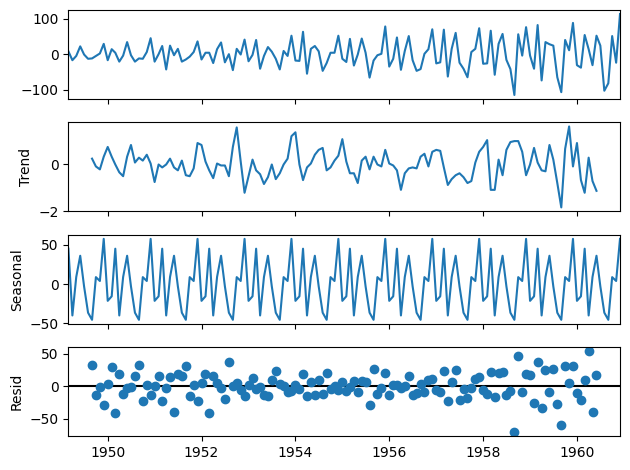

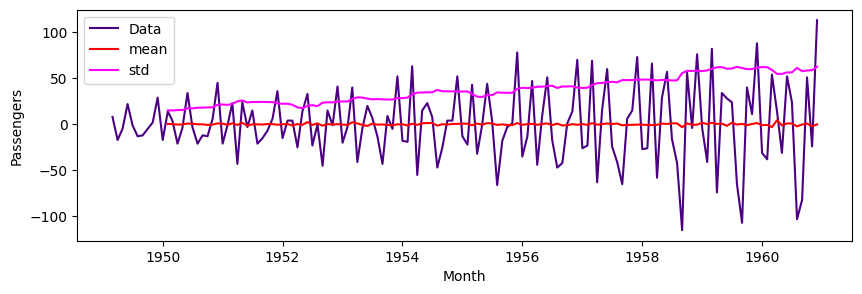

,result
Statistics,-16.384
p-value,0.000
Lags,11.000
Observations num,130.000
Critical value 1%,-3.482
Critical value 5%,-2.884
Critical value 10%,-2.579


In [28]:
double_diff = df_diff.diff().dropna()
dddec = sm.tsa.seasonal_decompose(double_diff, period=12).plot()
plt.show()
test_stationarity(double_diff)

We stil **got seasonality**, **no** particular **trend**, **p-value** is very low, approaching **zero** and **ADF statistics** is **lower than critical values**.

We assume such double **transformation would affect data too much**, so let's stick with just one diff() instead of the double.

### Trying other methods of transformation

#### log

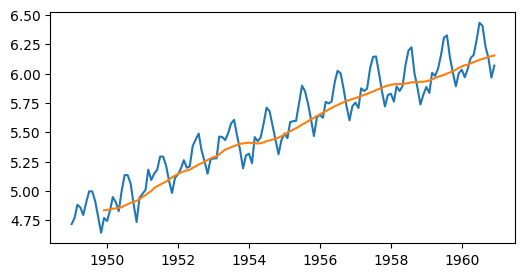

In [29]:
plt.figure(figsize=(6,3))
logdf = np.log(df)
plt.plot(logdf)
logroll = logdf.rolling(window=12)
plt.plot(logroll.mean())

Subtract moving average

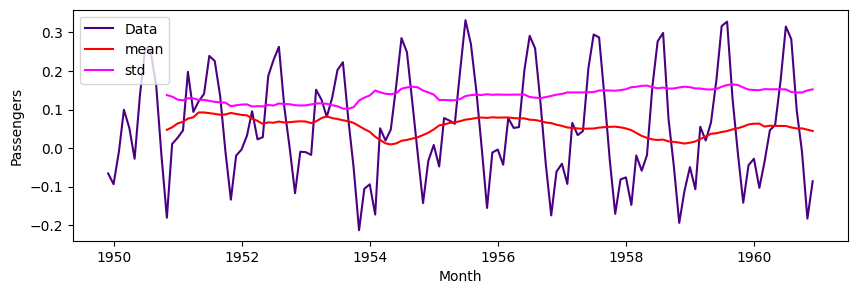

,result
Statistics,-3.163
p-value,0.022
Lags,13.000
Observations num,119.000
Critical value 1%,-3.487
Critical value 5%,-2.886
Critical value 10%,-2.580


In [30]:
logdf_no_ma = (logdf - logroll.mean()).dropna()
logresult = test_stationarity(logdf_no_ma)
logresult

In [31]:
logresult.rename(columns={'result':'log result'}, inplace=True)
logresult['diff result'] = difresult['result']
logresult

,log result,diff result
Statistics,-3.163,-2.829
p-value,0.022,0.054
Lags,13.000,12.000
Observations num,119.000,130.000
Critical value 1%,-3.487,-3.482
Critical value 5%,-2.886,-2.884
Critical value 10%,-2.580,-2.579


This one looks much betther than .diff() and **rejects null hypothesis**


p-value close to 2%, ADF stats between crit val 1% and 5%


#### Exponential decay

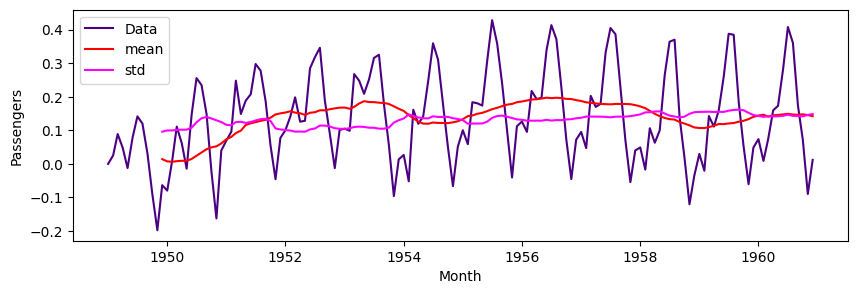

In [32]:
log_expo_ma = logdf.ewm(halflife=12, min_periods=0, adjust=True)
log_expo_no_ma = logdf - log_expo_ma.mean()
logexporesult = test_stationarity(log_expo_no_ma)

In [33]:
logresult['log exp decay'] = logexporesult['result']
logresult

,log result,diff result,log exp decay
Statistics,-3.163,-2.829,-3.601
p-value,0.022,0.054,0.006
Lags,13.000,12.000,13.000
Observations num,119.000,130.000,130.000
Critical value 1%,-3.487,-3.482,-3.482
Critical value 5%,-2.886,-2.884,-2.884
Critical value 10%,-2.580,-2.579,-2.579


Even better! but it's worth mentioning that the transformation has been performed on the already log-transformed  dataset

p-value dropped from 0.022 to 0.006, ADF closer to crit val 1%

####Time shift

Shift to the right

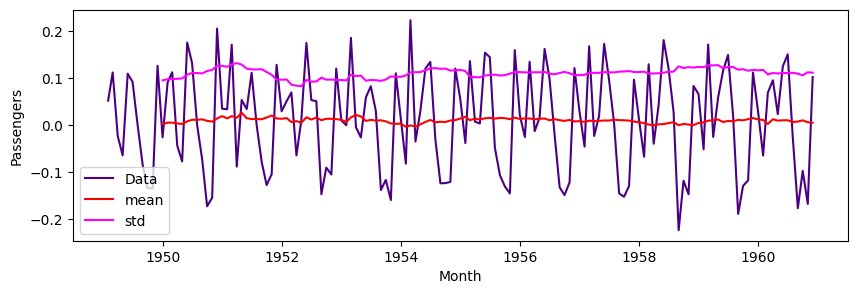

,log result,diff result,log exp decay,log time shift
Statistics,-3.163,-2.829,-3.601,-2.717
p-value,0.022,0.054,0.006,0.071
Lags,13.000,12.000,13.000,14.000
Observations num,119.000,130.000,130.000,128.000
Critical value 1%,-3.487,-3.482,-3.482,-3.483
Critical value 5%,-2.886,-2.884,-2.884,-2.884
Critical value 10%,-2.580,-2.579,-2.579,-2.579


In [34]:
logshift = test_stationarity((logdf - logdf.shift()).dropna())
logresult['log time shift'] = logshift['result']
logresult

This again, **fails** to reject null hypotesis, since **p-value 0.071** > 0.05, **ADF** stats **between** **crit val 10% and 5%** (no shit, Sherlock).

# ARIMA

**A**uto-**R**egressive **I**ntegrated **M**oving **A**verage

**p, d, q** - the order of ARIMA.

p - AR terms number

d - num of differencing order needed for TS to become stationary

q - num of lagged forecast errors

#### **p**

Auto-Regressive (AR) terms num

Number of lagged observations of the variable - reflects **infulence of past** values **on the current value**.

The higher p is the more complex dependancies are captured in the data (like window). How far back the model tries to capture the replationships between current value and past values.

$$ Y(t) = c + f_1 * Y(t-1) + f_2 * Y(t-2) + ... + f_p * Y(t-p) + ε(t)$$

Value_at_time_t = constant_intercept + lag_AR_coeff(1) * value_at_time(t-1) + **............** + lag_AR_coeff(p) * value_at_time(t-p) + white_noise(time_t)

#### **d**

Differencing order

Differencing is simple $diff =Y(t)-Y(t-1)$  - how different is current value from the previous one. It **removes** the **trend** and **stabilizes** **variance** to make the TS **more stationary**.

If data is stationary - d should be 0, if not, if it shows trend (but no seasonality - this is dealt with by **SARIMA**)- perform differencing. And again - d=1, d=2, d=3... . Be beware of introducing too much complexity

$$diff(t) = (Y(t)-Y(t-1)) - (Y(t-1)-Y(t-2)) - ...... - (Y(t-d+1)-Y(t-d))$$

#### **q**

Number of lagged prediction errors in the model (the number of MA terms). Captures linear relationships between current value and forecast error**s** from previous time period**s**. How far back should the model consider the influence of errors on the current value.

$$Error(t) = RealCurrentValue(t) - PredictedCurrentValue(t-1)$$


CurrentValue = intercept + MA_error_coef(1) * ewn(t-1) + ....... + MA_error_coef(q) * ewn(t-q) + ewn(q)

where ewn is error OR the white noise

$$Y(t) = c + θ_1 + ε(t-1) + θ_2 + ε(t-2) + ........ + θ_1 + ε(t-q) + ε(t)$$

### AutoCorrelation vs AutoREgression

To make it clear lets elaborate on these concepts

#### AutoCorrelation

Statistical **measure**

> Corelation between TS and it's lagged values at different points in time

> Quantifies degree of similarity between different points in time

> Measured using **ACF** which plots Correlation coeffs between TS and it's lagged values at various lags.

> High **AC** at specific lag means relationship between that lag and current values

#### AutoRegression

**Model**ling approach

> Modeling technique where TS is regressed at it's own lagged values to predict future values

> **AR** model uses one or more previousonservations to predict current value

> **AR(p)** uses values of TS at previous p steps

> **AR** model captures time dependencies and trends in data to predict based on patterns in past

## ACF/PACF

#### ACF

Auto-correlation function.

Helps identify the order of MA term.

Measures correlation between a TS and lagged values at n lags. Evaluates **how closely the values are related to their past values**.

High values mean higher correlation.

If ACF decays exponentially it suggests MA process.

#### PACF

Partial auto-correlation function

Help identify the order of AR term.

Measures correlation between a TS and lagged values controlling for the ntermediate value inbetween.

Represents **correlation that remains after removing linear dependancies explained by interveining lag**.

High value at lag k means direct relationships between lag k and value at lag k-1 independantly from other lags.

If PACF values cut off after a few lags, it suggests AR process.

If after a few lags PACF sharply drops off it is likely explained by intervening lag showing potential autocorrelation relationship thus adding AR term into ARIMA could be beneficial.

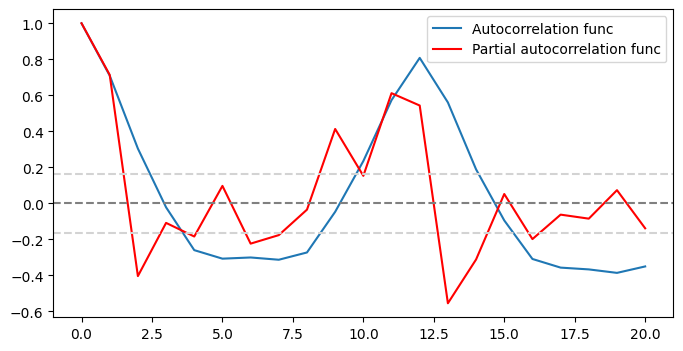

In [35]:
lag_acf = acf(log_expo_no_ma, nlags=20)
lag_pacf = pacf(log_expo_no_ma, nlags=20, method='ols')
perc_point = 1.96
plt.figure(figsize=(8,4))
plt.plot(lag_acf, label = 'Autocorrelation func')
plt.plot(lag_pacf, color='red', label='Partial autocorrelation func')
plt.axhline(y=perc_point/np.sqrt(len(log_expo_no_ma)), color = 'lightgrey', linestyle = '--')
plt.axhline(y=-perc_point/np.sqrt(len(log_expo_no_ma)), color = 'lightgrey', linestyle = '--')
plt.axhline(y=0, color = 'grey', linestyle = '--')
plt.legend()

In [36]:
def tsplot(y, lags=20, figsize=(9, 5), style='bmh'):

  with plt.style.context(style):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()
    plt.show()

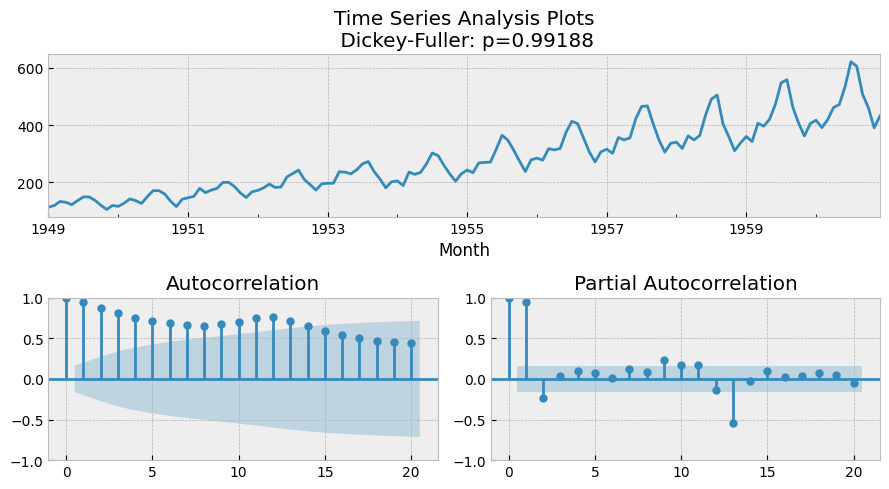

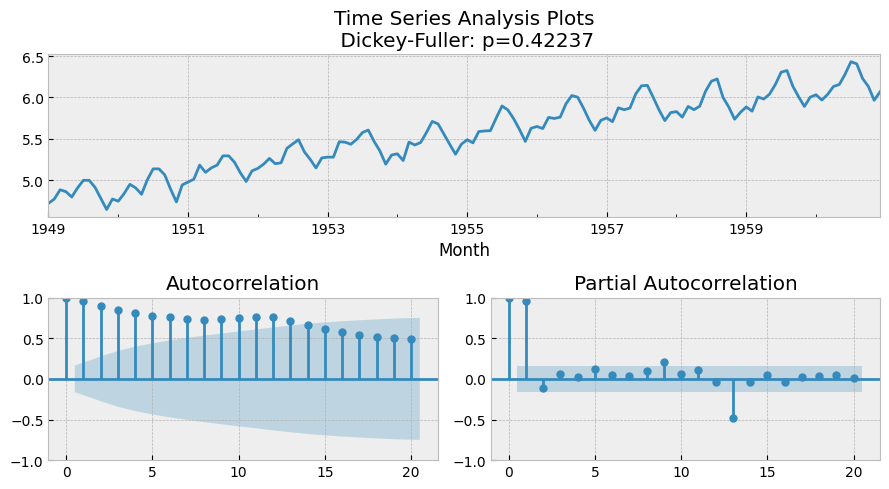

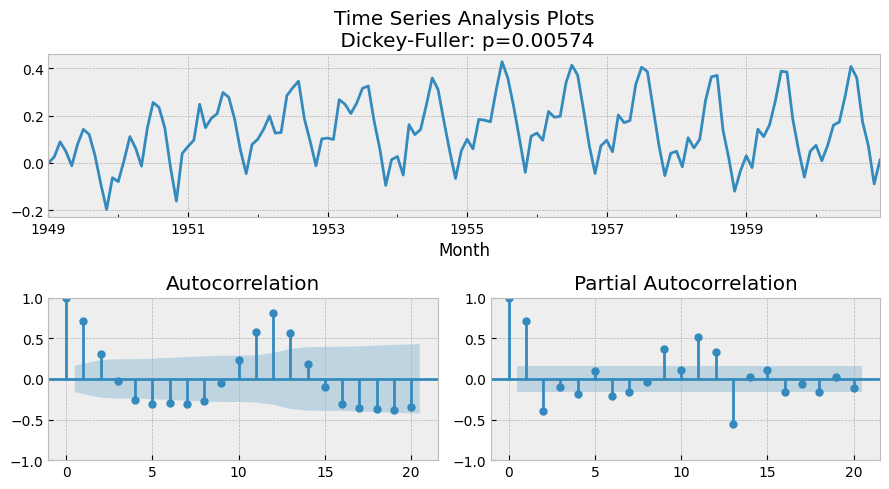

In [37]:
tsplot(df['Passengers'])
tsplot(logdf['Passengers'])
tsplot(log_expo_no_ma['Passengers'])

## Create the model

The order kw argument takes a tuple of (p, d, q).
For AR terms we are going to use **p**=2 to introduce 2 lags for AR.

We perform the differencing once since twice would after data too much, so **d**=1.

With the moving average terms we're going to experiment for **q** from zero to 2

#### To avoid Warnings for frequency (eventhough it's monthly anyway) we explicitly setmonthly frequency for TS

In [38]:
df = df.asfreq('MS')
logdf = logdf.asfreq('MS')
log_expo_no_ma = log_expo_no_ma.asfreq('MS')

### Metrics

To evaluate the model, apart from Info Criterions, log likelihood we'll be utilizing metrics such as RSS (residual sum of squares), MAE and RMSE

In [39]:
def roundme(num):
  return round(num, 2)

def get_ys(df, result):
  return df['Passengers'], result.fittedvalues

def get_metrics(df, result):
  y, y_pred = get_ys(df, result)
  rss = roundme(sum((y-y_pred)**2))
  mae = roundme(mean_absolute_error(y, y_pred))
  rmse = roundme(mean_squared_error(y, y_pred)**0.5)
  return rss, mae, rmse


It should be stated that since due to the **scale difference** of original and transformed **data**, they **cannot be** directly **compared**.

In [40]:
def plot_metrics(df, result):

  rss, mae, rmse = get_metrics(df, result)
  annotation = f'RSS: {rss}  MAE: {mae}  RMSE: {rmse}'

  plt.figure(figsize=(8,4))
  plt.plot(df['Passengers'])
  plt.plot(result.fittedvalues)
  plt.annotate(annotation, xy=(0.5, 0.9), xycoords='axes fraction', fontsize=12, ha='center')
  plt.show()


### ARIMA model

First we try ARIMA with no seasonal component (which would make it SARIMA).

Worth noting that the results now are printed as summary always indicate SARIMAX as a result, even when seasonal order is 0

#### Using data that hasn't been trasformed

In [41]:
model = ARIMA(df, order = (2, 1, 2), seasonal_order=(0,0,0,0))
dffit = model.fit()
print(dffit.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -671.673
Date:                Mon, 14 Aug 2023   AIC                           1353.347
Time:                        20:05:00   BIC                           1368.161
Sample:                    01-01-1949   HQIC                          1359.366
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6850      0.020     83.061      0.000       1.645       1.725
ar.L2         -0.9549      0.017    -55.420      0.000      -0.989      -0.921
ma.L1         -1.8432      0.124    -14.845      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**Log likelihood** is very **low**, **AIC** - Akaike Info criterion, **BIC** - Bayesian info criterion **HIQC** - Hannan-Quinn info criterion are **high**. That means the **data hasn't been fit properly** and the balance is bad. (Duh!)

**sigma2** - variance of residuals is extremely **high**, which means plenty of **values haven't been explained** by the model.

**Standard error** is **low** though, which is expected from a good fit.

**Z** is **skyhigh**, 83 STDs from zero is so far away and the (**P**)robability of observing such Z is **low**.

**Confidence intervals 2.5% and 97.5%** suggest that the lagged values are statstically **significant** and contribute to the model's performance.


**Ljung-Box test** - test applied to the first lag for AR presence in residuals **0.3** is a **magnitude**. **Prob(Q)** - the **high**er it is the more the probability there is no AR. In a good model we want it as low as possible.

**Jarque-Bera test** - test for normality of residuals. How far away are the residuals from normal distribution.

**Heteroscedasticity** - presence of non constant values is residuals.

**Skew** - is positive, so skewed to the right

**Kurtosis** - ~3 is normal distribution of residuals.

So kurtosis and Prob(JB) tell us about normally distributed residuals, other data suggests the model is terribly fit (and even failed to converge with given data at some point)


In [42]:
rss,mae, rmse = get_metrics(df, dffit)
print(f'Not transformed data\n\nRSS: {rss}\nMAE: {mae}\nRMSE: {rmse}')

Not transformed data

RSS: 110035.99
MAE: 20.85
RMSE: 27.64


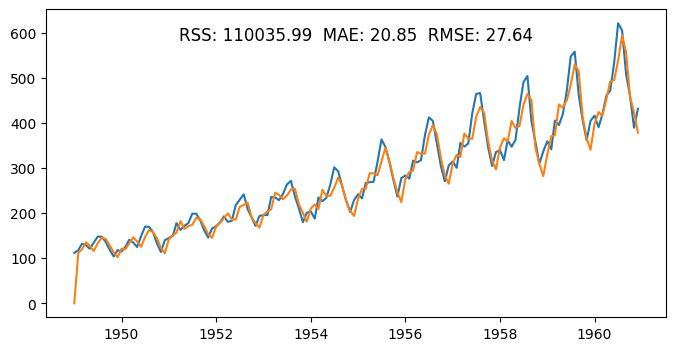

In [43]:
plot_metrics(df, dffit)

#### Log-transfromed data

In [44]:
logmodel = ARIMA(logdf, order = (2, 1, 2), seasonal_order=(0,0,0,0))
logfit = logmodel.fit()
print(logfit.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 128.890
Date:                Mon, 14 Aug 2023   AIC                           -247.780
Time:                        20:05:02   BIC                           -232.965
Sample:                    01-01-1949   HQIC                          -241.760
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2432      0.166      1.469      0.142      -0.081       0.568
ar.L2          0.2677      0.199      1.344      0.179      -0.123       0.658
ma.L1         -0.0867      0.118     -0.732      0.4

This model show better results on everything but residuals distribution.

Introducing lag 2 for MA term worsens the result a little bit but we haven't removed MA after all.

**Log likelihood** is positive and **high** and **Info Criterions** are much **better** (lower) and **Z score** is **lower** for auto-correlation. And **sigma** is **much lower** which means the data has been explained by the model much better.

Data is slightly negativelly skewed. Residuals kurtosis 1.92 compared to 3 means they are  less peaked and got thinner tail. Even though JB tests show a large value.

Prob(H) means the chance of **heretoscedasticity** is **lower**, which is better since we usually want homoscedasticity - relativelly constant spread and constistant variability of error across variables.

Confidence intervals are narrower.

In [45]:
rss,mae, rmse = get_metrics(logdf, logfit)
print(f'Log-transformed data\n\nRSS: {rss}\nMAE: {mae}\nRMSE: {rmse}')

Log-transformed data

RSS: 23.64
MAE: 0.12
RMSE: 0.41


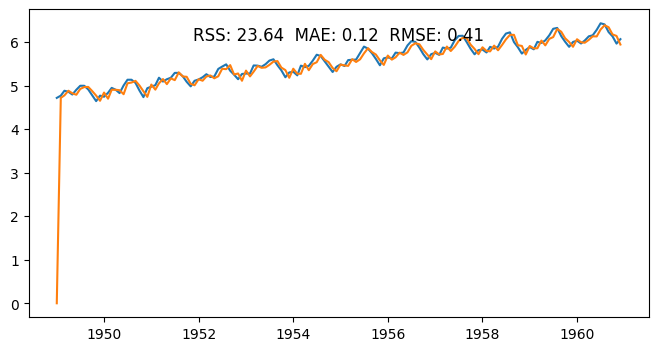

In [46]:
plot_metrics(logdf, logfit)

Let's remove the first value

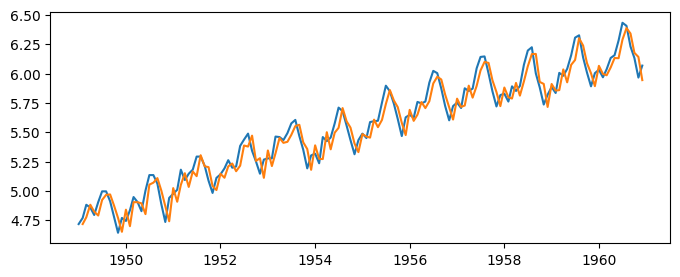

In [47]:
plt.figure(figsize=(8,3))
plt.plot(logdf)
plt.plot(logfit.fittedvalues[1:])

In [48]:
modellog = ARIMA(logdf, order=(2,1,2))
resultlog = modellog.fit()
cumsum_log = resultlog.fittedvalues

#### Log-trasformed exponential decayed data with Moving Average removed. (double expo log transformation)

Since we've removed Moving average from the dataset we set **q=0**

In [49]:
logexponoma = ARIMA(log_expo_no_ma, order = (2, 1, 0), seasonal_order=(0,0,0,0))
lemafit = logexponoma.fit()
print(lemafit.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 128.367
Date:                Mon, 14 Aug 2023   AIC                           -250.734
Time:                        20:05:05   BIC                           -241.846
Sample:                    01-01-1949   HQIC                          -247.122
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2308      0.098      2.346      0.019       0.038       0.424
ar.L2         -0.1698      0.097     -1.757      0.079      -0.359       0.020
sigma2         0.0097      0.002      6.098      0.0

Judging by the result, **compared to** simply **log**-transformed **data**, the model has performed slightly **worse**.
Normally it's is expected that transformation at least won't make it worse, but in or case it's irrelevant. Adding exponential decay didn't help model predict better even though as we remember p-value was much lower and ADF result was closer to crit value 1% than to 5%.

In [50]:
rss,mae, rmse = get_metrics(log_expo_no_ma, lemafit)
print(f'Log-transformed data with exponential decay applied\n\nRSS: {rss}\nMAE: {mae}\nRMSE: {rmse}')

Log-transformed data with exponential decay applied

RSS: 1.39
MAE: 0.08
RMSE: 0.1


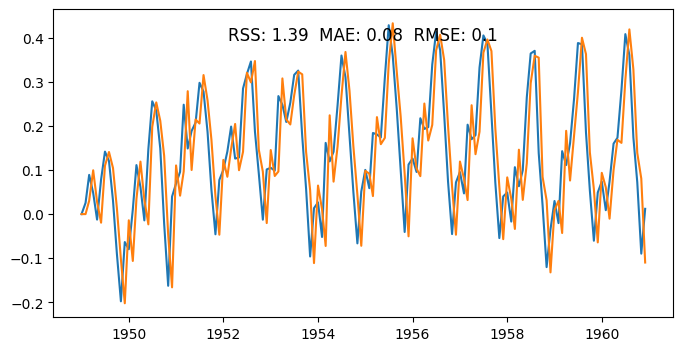

In [51]:
plot_metrics(log_expo_no_ma, lemafit)

Actually adding Moving Average term (lag 2) would decrease RSS but lower the peaks

### Let's try 0 AR term and lag2 MA term

In [52]:
df_names = ('Original DF', 'Log-transformed DF', 'Log with exponent decay DF')
dfs = (df, logdf, log_expo_no_ma)
#lag2 on MA for model with removed MA... hmmm
results = []

for ds in dfs:
  mdl = ARIMA(ds, order = (0,1,2))
  results.append(mdl.fit())

			Original DF

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -695.547
Date:                Mon, 14 Aug 2023   AIC                           1397.093
Time:                        20:05:07   BIC                           1405.982
Sample:                    01-01-1949   HQIC                          1400.705
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3822      0.072      5.283      0.000       0.240       0.524
ma.L2         -0.2633      0.062     -4.256      0.000      -0.384      -0.142
sigma2       979.2956    111.655    

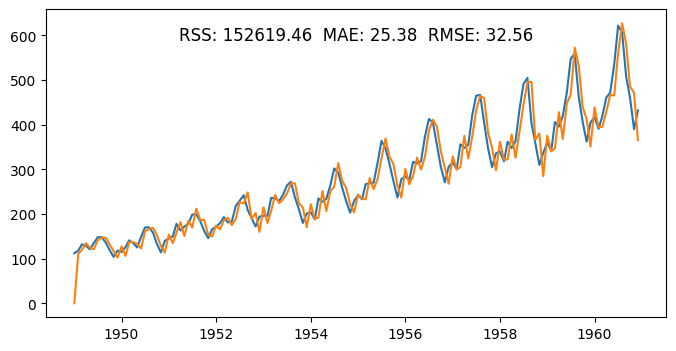





			Log-transformed DF

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 123.423
Date:                Mon, 14 Aug 2023   AIC                           -240.847
Time:                        20:05:08   BIC                           -231.958
Sample:                    01-01-1949   HQIC                          -237.235
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2344      0.085      2.757      0.006       0.068       0.401
ma.L2         -0.2830      0.078     -3.613      0.000      -0.437      -0.130
sigma2         0.0104    

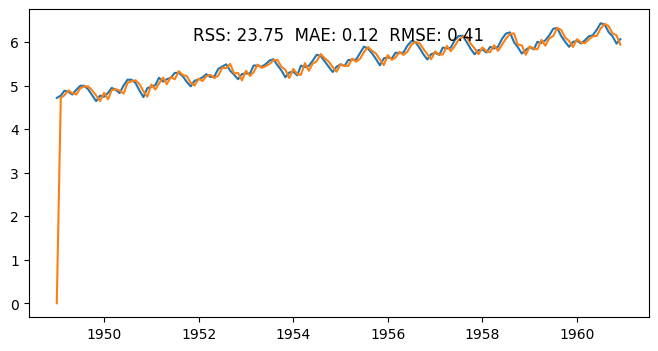





			Log with exponent decay DF

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 129.799
Date:                Mon, 14 Aug 2023   AIC                           -253.598
Time:                        20:05:09   BIC                           -244.710
Sample:                    01-01-1949   HQIC                          -249.986
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1910      0.081      2.347      0.019       0.032       0.350
ma.L2         -0.3558      0.074     -4.782      0.000      -0.502      -0.210
sigma2         0.

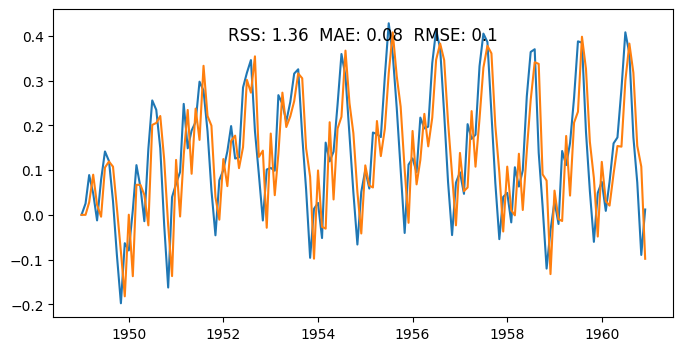

In [53]:
for i in range(len(df_names)):
  print('\t'*3 + df_names[i]+'\n')
  print(results[i].summary())
  plot_metrics(dfs[i], results[i])
  print('\n'*3)

## In-Sample Forecast

Similar to train and validation for regular ML tasks

In [54]:
def split(df, size=30):
  log_train = df['Passengers'][:-size]
  log_val = df['Passengers'][-size:]
  return log_train, log_val

#### retrain the model every time after predictions

In [55]:
def plotme(df1, df2):
  plt.figure(figsize=(8,4))
  plt.plot(df1['Passengers'],label = 'Real')
  plt.plot(df2, label = 'Predicted')
  plt.legend(loc="upper left")
  plt.show()

In [65]:
def isf_predictions(df, size = 30, model = 'arima'):
  train, test = split(df, size)
  historical_values = [x for x in train]
  preds = []
  for t in range(len(test)):
    y = test[t]
    if model.lower()=='sarima':
      isf_model = sm.tsa.statespace.SARIMAX(historical_values, order = (2,1,2), seasonal_order = (0,1,1,12))
    else:
      isf_model = ARIMA(historical_values, order = (2,1,2), seasonal_order = (0,0,0,0))

    isf_fit = isf_model.fit()
    isf_predict = isf_fit.forecast()
    y_pred = float(isf_predict[0])
    preds.append(y_pred)
    err = round(y-y_pred, 2)
    print(f'Predicted: {round(y_pred,2)}, real: {y}, error: {err}, {round(abs(err)/y*100, 2)}%')
    historical_values.append(y)
  print(f'RSME: {round(mean_squared_error(test, preds), 3)}')
  result = pd.Series(preds, index = test.index)
  plotme(df, result)
  return result

Predicted: 6.06, real: 6.19644412779452, error: 0.13, 2.1%
Predicted: 6.17, real: 6.22455842927536, error: 0.06, 0.96%
Predicted: 6.17, real: 6.0014148779611505, error: -0.17, 2.83%
Predicted: 5.93, real: 5.883322388488279, error: -0.05, 0.85%
Predicted: 5.91, real: 5.736572297479192, error: -0.18, 3.14%
Predicted: 5.72, real: 5.820082930352362, error: 0.1, 1.72%
Predicted: 5.91, real: 5.886104031450156, error: -0.02, 0.34%
Predicted: 5.86, real: 5.834810737062605, error: -0.03, 0.51%
Predicted: 5.86, real: 6.0063531596017325, error: 0.15, 2.5%
Predicted: 6.03, real: 5.981414211254481, error: -0.05, 0.84%
Predicted: 5.93, real: 6.040254711277414, error: 0.11, 1.82%
Predicted: 6.07, real: 6.156978985585555, error: 0.09, 1.46%
Predicted: 6.12, real: 6.306275286948016, error: 0.19, 3.01%
Predicted: 6.3, real: 6.326149473155099, error: 0.02, 0.32%
Predicted: 6.25, real: 6.137727054086234, error: -0.11, 1.79%
Predicted: 6.1, real: 6.008813185442595, error: -0.09, 1.5%
Predicted: 6.0, real: 

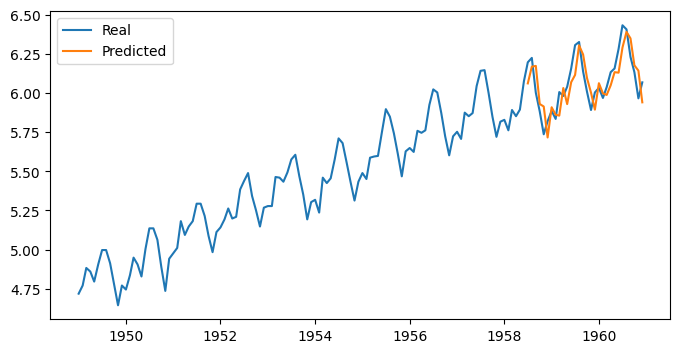

In [66]:
isf_pred = isf_predictions(logdf)

### Out-of-sample forecast

We create synthetic camples on more frequent intervals - weeks in our case. It's basically more specific upscaling.

In [67]:
def plotfp(forecast):
    plt.figure(figsize=(12, 8))
    plt.plot(forecast.index, forecast['Passengers'], label='Original Data')
    plt.plot(forecast.index, forecast['ARIMA_predict'], label='ARIMA Predict Function', color='green')
    plt.xlabel('Date')
    plt.ylabel('Passengers')
    plt.title('Original Data vs. ARIMA Forecast/Predict Functions')
    plt.legend()
    plt.show()

Forecast and predict produce the same output for this dataset

In [68]:
def outsampling(df, exp = False):
  future_dates = [df.index[-1] + DateOffset(weeks = x) for x in range(0,49)]
  df_week = pd.DataFrame(index = future_dates[1:],columns = df.columns)

  forecast = pd.concat([df, df_week])
  forecast['ARIMA_Forecast_Function'] = np.NaN
  ARIMA_history_f = [x for x in df['Passengers']]
  f1 = []

  for t in range(len(df_week)):

      model = ARIMA(ARIMA_history_f, order = (2,1,2))
      model_fit = model.fit()

      output = model_fit.forecast()[0]

      ARIMA_history_f.append(output)
      f1.append(output)

  for i in range(len(f1)):
      forecast.iloc[144 + i, 1] = f1[i]
  if exp:
    forecast['ARIMA_Forecast_Function'] = np.exp(forecast['ARIMA_Forecast_Function'])#.applt(np.exp, inplace=True)
  forecast[['Passengers','ARIMA_Forecast_Function']].plot(figsize = (6,4))
  return forecast

ORIGINAL DF


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

LOG DF


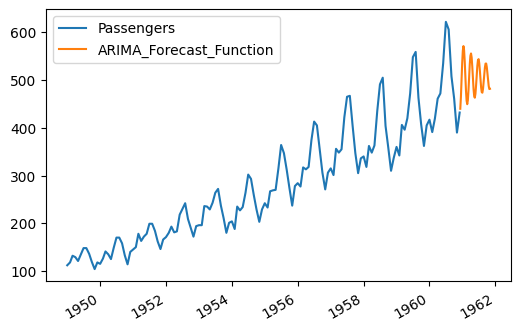

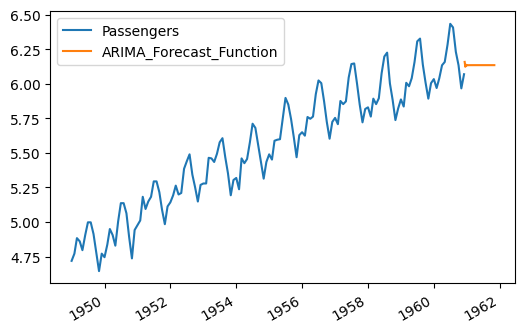

In [69]:
print('ORIGINAL DF')
outsampled_df = outsampling(df)
print('LOG DF')
outsampled_logdf = outsampling(logdf)

Can't say the model picked the difference and seasonality.

# SARIMA

SARIMA takes into account seasonal effect of data.

### SARIMA order is **(p, d, q) x (P, D, Q, M)**

#### PDQ

**p, d, q** - this kind of order **same** as the order of **ARIMA**.

> **p** - **AR** terms number

> **d** - num of **differencing** order needed for TS to become stationary

> **q** - num of lagged forecast **errors**

#### PDQM - seasonal order

 > **P** - seassonal AR term - number of AR terms at season lag, dependency of current value on previous from the same season

 > **D** - num of diff needed to make the series stationary.

 > **Q** - seasonal MA. Number of lagged forecast errors. Effect of past errors on current observation.

 > **M** - new term! Length of seasonal periods. How often does the pattern repeat. I.e. if data got montly seasonality, M would be 12 since 112 months in a year.  

> Also **E** could be taken into account - **Exogenous Regressors**- some effect that is not a part of TS but could be included. Different variables that affect TS (like pandemics, crisis, war, etc). Basically - **external variables**.

### Check data

Let's diff already diff'd data (12M->Y)

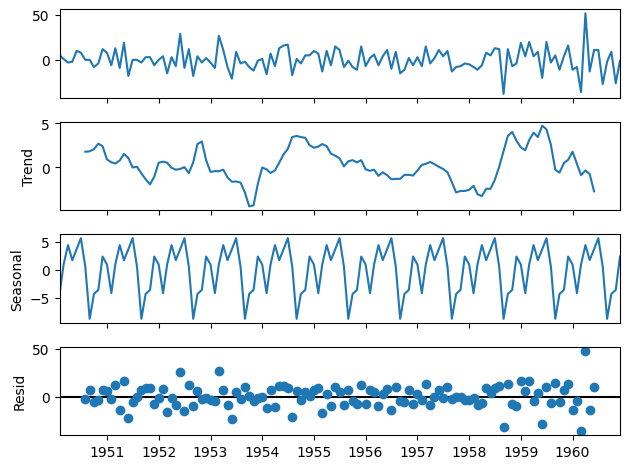

In [70]:
sdiffdf = df_diff.diff(12).dropna()
sdec = sm.tsa.seasonal_decompose(sdiffdf, period=12)
sdec.plot()
plt.show()

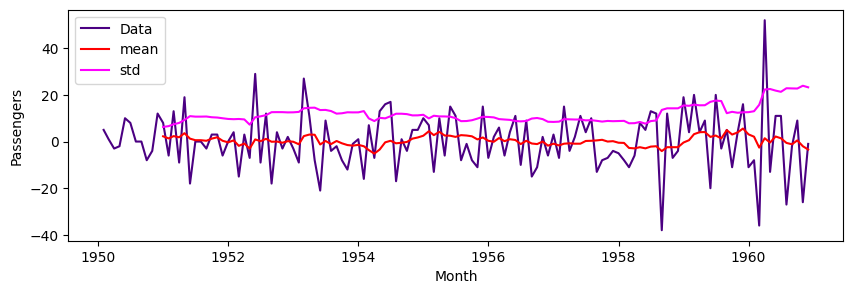

,result
Statistics,-15.596
p-value,0.000
Lags,0.000
Observations num,130.000
Critical value 1%,-3.482
Critical value 5%,-2.884
Critical value 10%,-2.579


In [71]:
test_stationarity(sdiffdf)

p-value close to 0. crit value 1% less than DFtest stats, so we can state that most probably TS is stationary. Rolling mean is close to 0, std slightly deviates.

#### Thus we can **reject null hypothesis** that data is not stationary.

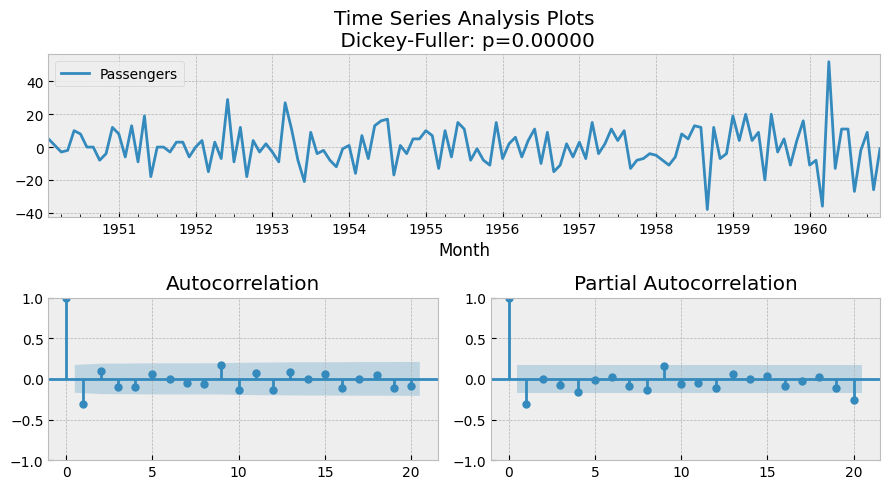

In [72]:
tsplot(sdiffdf)

## Perform SARIMA

The (p,d,q) order will be the same, (P,D,Q,M) will be (0,1,1,12)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


			Original DF

                                      SARIMAX Results                                       
Dep. Variable:                           Passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -503.968
Date:                              Mon, 14 Aug 2023   AIC                           1019.935
Time:                                      20:13:04   BIC                           1037.186
Sample:                                  01-01-1949   HQIC                          1026.945
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3966      0.422      0.940      0.347      -0.430       1.223
ar.

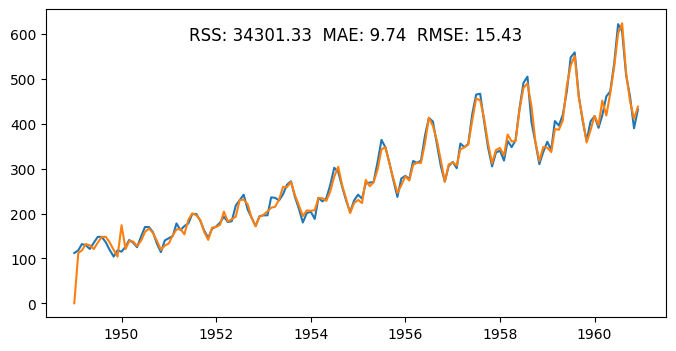





			Log-transformed DF

                                      SARIMAX Results                                       
Dep. Variable:                           Passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood                 245.819
Date:                              Mon, 14 Aug 2023   AIC                           -479.639
Time:                                      20:13:04   BIC                           -462.388
Sample:                                  01-01-1949   HQIC                          -472.629
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1494      0.831      0.180      0.857      -1.479     

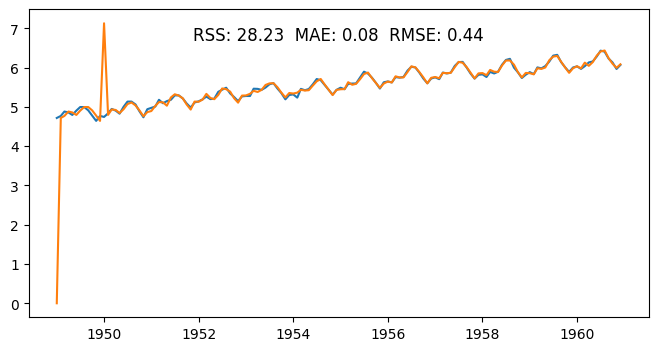





			Log with exponent decay DF

                                      SARIMAX Results                                       
Dep. Variable:                           Passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood                 249.019
Date:                              Mon, 14 Aug 2023   AIC                           -486.037
Time:                                      20:13:05   BIC                           -468.786
Sample:                                  01-01-1949   HQIC                          -479.028
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1728      0.744      0.232      0.816      -1.

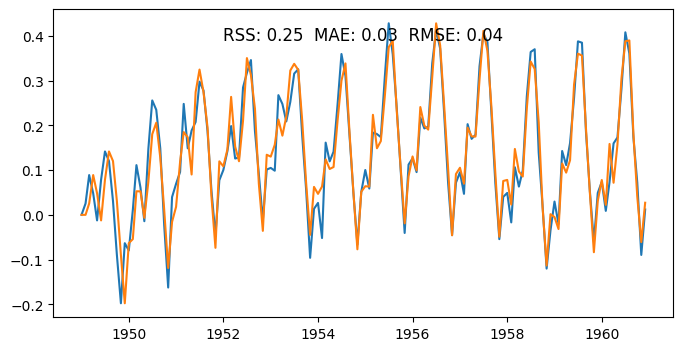

In [73]:
df_names = ('Original DF', 'Log-transformed DF', 'Log with exponent decay DF')
dfs = (df, logdf, log_expo_no_ma)
#lag2 on MA for model with removed MA... hmmm
sresults = []

for ds in dfs:
  mdl = sm.tsa.statespace.SARIMAX(ds['Passengers'], order = (2,1,2), seasonal_order = (0,1,1,12))
  sresults.append(mdl.fit())

for i in range(len(df_names)):
  print('\t'*3 + df_names[i]+'\n')
  print(sresults[i].summary())
  plot_metrics(dfs[i], sresults[i])
  print('\n'*3)

**Higher Log_likelihood, lower Info Criterion, lower sigma, low z.**

And as it is seen from the graph - **data** has been **fit** much **better**.

### Test In-Sampling Forecasting

In [74]:
def test_sarima(df, sample=30):
  size = int(len(df) - sample)
  train, test = df['Passengers'][0:size], df['Passengers'][size:len(data)]
  print('\t SARIMA MODEL : In - Sample Forecasting \n')

  history = [x for x in train]
  predictions = []

  for t in range(len(test)):
      model = sm.tsa.statespace.SARIMAX(history,order = (2,1,2),seasonal_order = (0,1,1,12))
      model_fit = model.fit()
      output = model_fit.forecast()
      yhat = output[0]
      predictions.append(float(yhat))
      y = test[t]
      history.append(y)
      err = round(y-yhat, 2)
      print(f'predicted: {round(yhat, 2)}, expected: {round(y, 2)} error: {err}, {round(abs(err)/y*100, 2)}%')

  predictions_series = pd.Series(predictions, index = test.index)
  print(f'RMSE: {np.sqrt(mean_squared_error(test, predictions))}')
  plt.plot(df['Passengers'], label = 'Expected Values')
  plt.plot(predictions_series, label = 'Predicted Values')
  plt.legend(loc="upper left")
  plt.show()

	 SARIMA MODEL : In - Sample Forecasting 

predicted: 479.09, expected: 491 error: 11.91, 2.43%
predicted: 490.55, expected: 505 error: 14.45, 2.86%
predicted: 441.28, expected: 404 error: -37.28, 9.23%
predicted: 357.27, expected: 359 error: 1.73, 0.48%
predicted: 315.25, expected: 310 error: -5.25, 1.69%
predicted: 347.83, expected: 337 error: -10.83, 3.21%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: 344.25, expected: 360 error: 15.75, 4.38%
predicted: 336.84, expected: 342 error: 5.16, 1.51%
predicted: 387.59, expected: 406 error: 18.41, 4.53%
predicted: 387.33, expected: 396 error: 8.67, 2.19%
predicted: 408.19, expected: 420 error: 11.81, 2.81%
predicted: 485.99, expected: 472 error: -13.99, 2.96%
predicted: 529.03, expected: 548 error: 18.97, 3.46%
predicted: 551.91, expected: 559 error: 7.09, 1.27%
predicted: 459.06, expected: 463 error: 3.94, 0.85%
predicted: 411.97, expected: 407 error: -4.97, 1.22%
predicted: 358.42, expected: 362 error: 3.58, 0.99%
predicted: 384.95, expected: 405 error: 20.05, 4.95%
predicted: 420.14, expected: 417 error: -3.14, 0.75%
predicted: 397.76, expected: 391 error: -6.76, 1.73%
predicted: 451.34, expected: 419 error: -32.34, 7.72%
predicted: 415.68, expected: 461 error: 45.32, 9.83%
predicted: 465.3, expected: 472 error: 6.7, 1.42%
predicted: 529.84, expected: 535 error: 5.16, 0.96%
predicted: 599.3, expected: 622 error: 22.7, 3.65%
pr

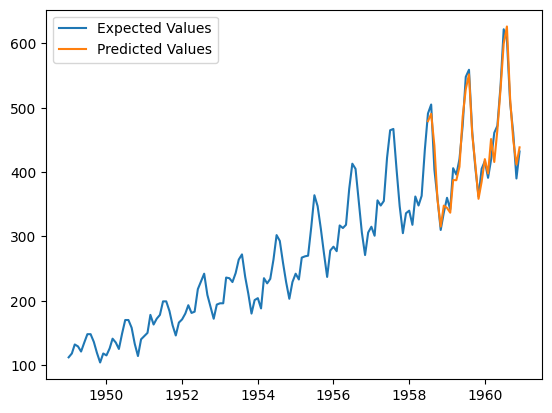

In [75]:
test_sarima(df)

	 SARIMA MODEL : In - Sample Forecasting 

predicted: 6.18, expected: 6.2 error: 0.02, 0.32%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: 6.19, expected: 6.22 error: 0.04, 0.64%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: 6.09, expected: 6.0 error: -0.09, 1.5%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: 5.89, expected: 5.88 error: -0.0, 0.0%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: 5.75, expected: 5.74 error: -0.01, 0.17%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: 5.87, expected: 5.82 error: -0.05, 0.86%
predicted: 5.85, expected: 5.89 error: 0.03, 0.51%
predicted: 5.83, expected: 5.83 error: 0.01, 0.17%
predicted: 5.98, expected: 6.01 error: 0.02, 0.33%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: 5.97, expected: 5.98 error: 0.01, 0.17%
predicted: 6.0, expected: 6.04 error: 0.04, 0.66%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: 6.2, expected: 6.16 error: -0.04, 0.65%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: 6.28, expected: 6.31 error: 0.02, 0.32%
predicted: 6.3, expected: 6.33 error: 0.03, 0.47%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: 6.15, expected: 6.14 error: -0.01, 0.16%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: 6.01, expected: 6.01 error: -0.0, 0.0%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: 5.87, expected: 5.89 error: 0.02, 0.34%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: 5.99, expected: 6.0 error: 0.02, 0.33%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: 6.04, expected: 6.03 error: -0.0, 0.0%
predicted: 5.98, expected: 5.97 error: -0.01, 0.17%
predicted: 6.13, expected: 6.04 error: -0.09, 1.49%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: 6.04, expected: 6.13 error: 0.09, 1.47%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: 6.14, expected: 6.16 error: 0.02, 0.32%
predicted: 6.31, expected: 6.28 error: -0.03, 0.48%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: 6.41, expected: 6.43 error: 0.02, 0.31%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: 6.44, expected: 6.41 error: -0.03, 0.47%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: 6.24, expected: 6.23 error: -0.01, 0.16%
predicted: 6.1, expected: 6.13 error: 0.03, 0.49%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: 6.0, expected: 5.97 error: -0.03, 0.5%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: 6.09, expected: 6.07 error: -0.02, 0.33%
RMSE: 0.03682940876429196


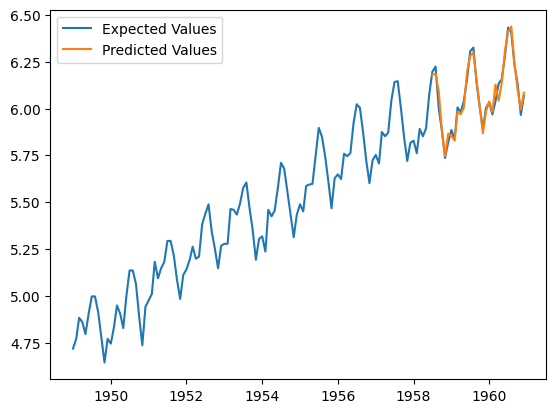

In [76]:
test_sarima(logdf)

	 SARIMA MODEL : In - Sample Forecasting 



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: 0.34, expected: 0.36 error: 0.02, 5.49%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: 0.33, expected: 0.37 error: 0.04, 10.81%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: 0.22, expected: 0.14 error: -0.08, 57.67%
predicted: 0.02, expected: 0.02 error: 0.0, 0.0%
predicted: -0.12, expected: -0.12 error: -0.0, -0.0%
predicted: 0.0, expected: -0.03 error: -0.04, -115.72%
predicted: -0.01, expected: 0.03 error: 0.04, 134.74%
predicted: -0.03, expected: -0.02 error: 0.01, -49.04%
predicted: 0.12, expected: 0.14 error: 0.03, 21.03%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: 0.1, expected: 0.11 error: 0.01, 9.0%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: 0.13, expected: 0.16 error: 0.03, 18.7%
predicted: 0.29, expected: 0.26 error: -0.03, 11.47%
predicted: 0.36, expected: 0.39 error: 0.03, 7.74%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: 0.36, expected: 0.38 error: 0.03, 7.8%
predicted: 0.2, expected: 0.19 error: -0.01, 5.4%
predicted: 0.05, expected: 0.05 error: 0.0, 0.0%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: -0.08, expected: -0.06 error: 0.02, -33.14%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: 0.03, expected: 0.05 error: 0.02, 40.83%
predicted: 0.08, expected: 0.07 error: -0.0, 0.0%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: 0.02, expected: 0.01 error: -0.01, 112.54%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: 0.16, expected: 0.07 error: -0.08, 108.6%
predicted: 0.07, expected: 0.16 error: 0.09, 56.36%
predicted: 0.15, expected: 0.17 error: 0.02, 11.56%
predicted: 0.31, expected: 0.28 error: -0.03, 10.66%
predicted: 0.39, expected: 0.41 error: 0.02, 4.9%
predicted: 0.39, expected: 0.36 error: -0.03, 8.32%
predicted: 0.18, expected: 0.17 error: -0.01, 5.76%
predicted: 0.04, expected: 0.07 error: 0.03, 41.48%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: -0.06, expected: -0.09 error: -0.03, -33.48%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted: 0.03, expected: 0.01 error: -0.02, 167.16%
RMSE: 0.03532656351191697


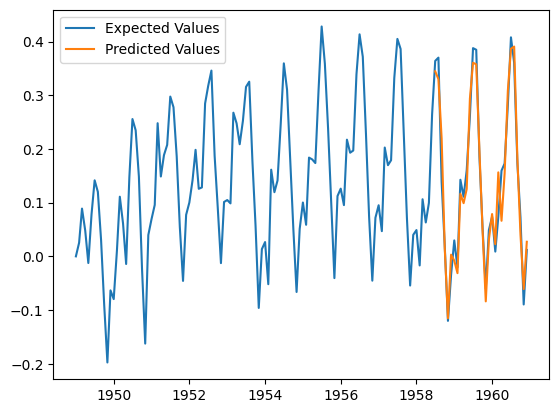

In [77]:
test_sarima(log_expo_no_ma)

### Out-of-Sample Forecast

In [78]:
def oof_sarima(df, forecast, size = 30):
  size = int(len(df) - size)
  train, test = df['Passengers'][0:size], df['Passengers'][size:len(df)]
  SARIMA_history = [x for x in train]
  future_dates = [df.index[-1] + DateOffset(weeks = x) for x in range(0,49)]
  df1 = pd.DataFrame(index = future_dates[1:],columns = df.columns)

  forecastx = outsampled_df.copy()
  forecastx['SARIMA_pred'] = np.NaN
  f = []

  for t in (range(len(df1))):
      model = sm.tsa.statespace.SARIMAX(SARIMA_history,order = (2,1,2),seasonal_order = (0,1,1,12))
      model_fit = model.fit()
      output = model_fit.forecast()[0]
      SARIMA_history.append(output)
      f.append(output)
  for i in range(len(f)):
      forecastx.iloc[144 + i, 2] = f[i]
  return forecastx

In [79]:
sarima_os_df = oof_sarima(df, outsampled_df)
sarima_os_df.tail()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Passengers,ARIMA_Forecast_Function,SARIMA_pred
1961-10-05,NaN,514.277393,423.787530
1961-10-12,NaN,499.820491,469.382990
1961-10-19,NaN,487.728513,456.604340
1961-10-26,NaN,481.163887,471.069967
1961-11-02,NaN,481.673957,542.694523


<Axes: >

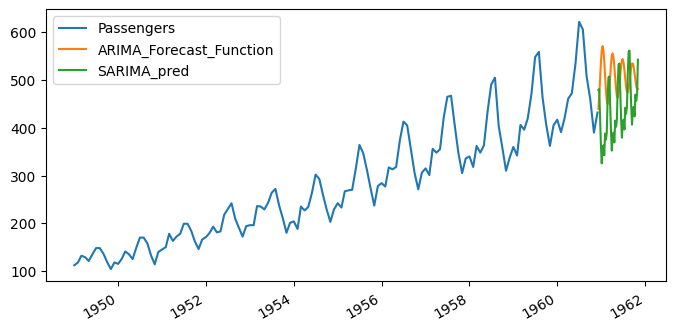

In [80]:
sarima_os_df[['Passengers', 'ARIMA_Forecast_Function', 'SARIMA_pred']].plot(figsize = (8,4))

Unlike ARIMA, **SARIMA** **predicted** the **trend better**, but still **hasn't predicted** the seasonality that every season the **peaks become wider**

In [81]:
sarima_os_logdf = oof_sarima(logdf, outsampled_logdf)
sarima_os_logdf['SARIMA_pred'] = sarima_os_logdf['SARIMA_pred'].apply(lambda x: np.exp(x))
sarima_os_logdf.tail()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

,Passengers,ARIMA_Forecast_Function,SARIMA_pred
1961-10-05,NaN,514.277393,467.411477
1961-10-12,NaN,499.820491,540.734959
1961-10-19,NaN,487.728513,526.261560
1961-10-26,NaN,481.163887,539.572406
1961-11-02,NaN,481.673957,636.282655


<Axes: >

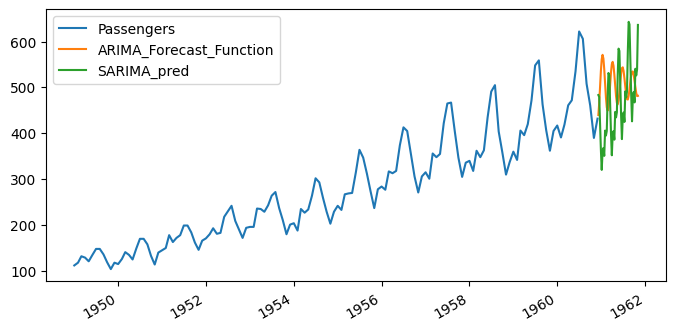

In [82]:
sarima_os_logdf.plot(figsize = (8,4))

<Axes: >

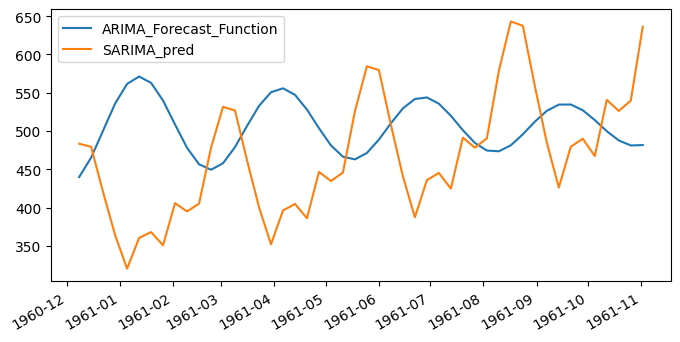

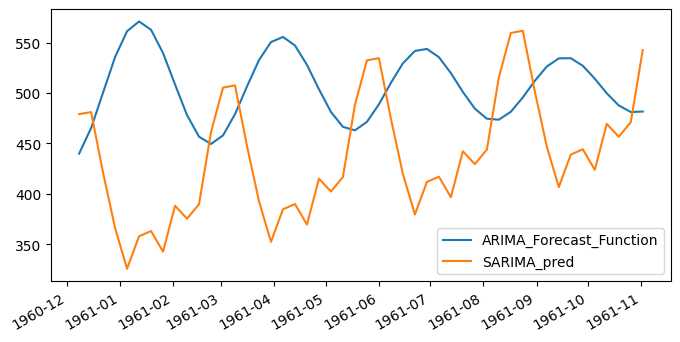

In [83]:
sarima_os_logdf[['ARIMA_Forecast_Function', 'SARIMA_pred']].plot(figsize = (8,4))
sarima_os_df[['ARIMA_Forecast_Function', 'SARIMA_pred']].plot(figsize = (8,4))

That was the seasonality and trend

In [84]:
def plotsa(pas = False):
  plt.figure(figsize=(12, 4))
  if pas:
    plt.plot(df['Passengers'], label = 'Passengers')
  names = ['df', 'logdf']
  sarimas = [sarima_os_df, sarima_os_logdf]
  for name in ['ARIMA_Forecast_Function', 'SARIMA_pred']:
    for n in range(len(names)):
      plt.plot(sarimas[n][name], label = names[n]+' '+name)
  plt.legend()

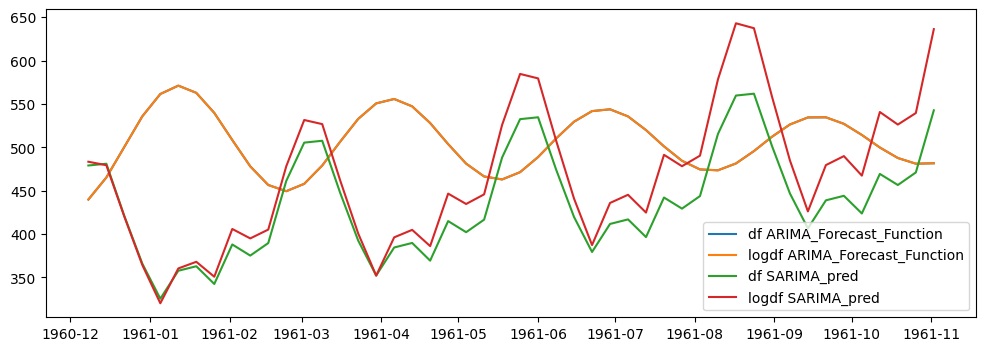

In [85]:
plotsa()

ARIMA OOS preds don't change for df and logdf, but SARIMA's do

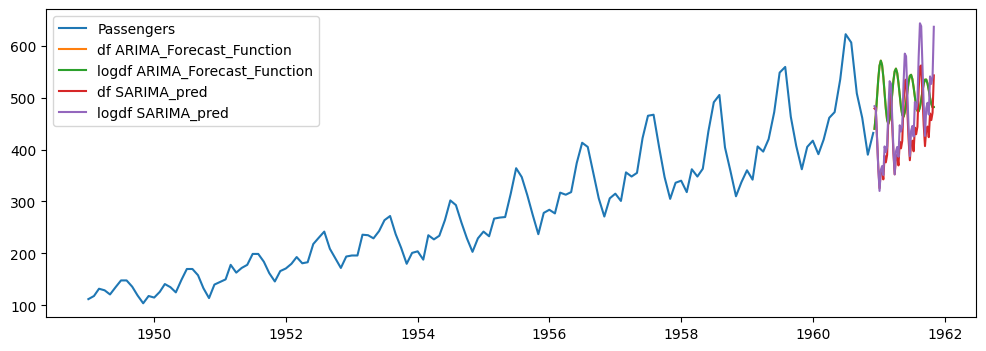

In [86]:
plotsa(True)

## Try XGBoost just for lulz

In [87]:
from sklearn.model_selection import train_test_split

In [104]:
def prepare_for_boost(df):
  df = df.copy()
  for i in range(1, 4):
    lag = str(i)
    df['lag_'+lag] = df['Passengers'].shift(i)
  df.dropna(inplace=True)

  split_index = int(len(df) * 0.8)
  train = df.iloc[:split_index]
  test = df.iloc[split_index:]

  X_train = train.drop('Passengers', axis=1)
  X_test = test.drop('Passengers', axis=1)
  y_train = train['Passengers']
  y_test = test['Passengers']
  return (X_train, X_test, y_train, y_test)


In [156]:
def boost(df):
  X_train, X_test, y_train, y_test = prepare_for_boost(df)

  model = xgb.XGBRegressor(objective='reg:squarederror')
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)

  rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 4)
  mse = round(mean_squared_error(y_test, y_pred), 4)
  mae = round(mean_absolute_error(y_test, y_pred), 4)
  text = f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}'

  plt.figure(figsize=(8,4))
  predicted_df = pd.DataFrame(data=y_pred, index=y_test.index, columns=['Passengers'])
  plt.plot(df.index, df['Passengers'], label='Original', color='blue')
  plt.plot(predicted_df.index, predicted_df['Passengers'], label='Predicted', color='red')
  plt.title(text)
  plt.show()

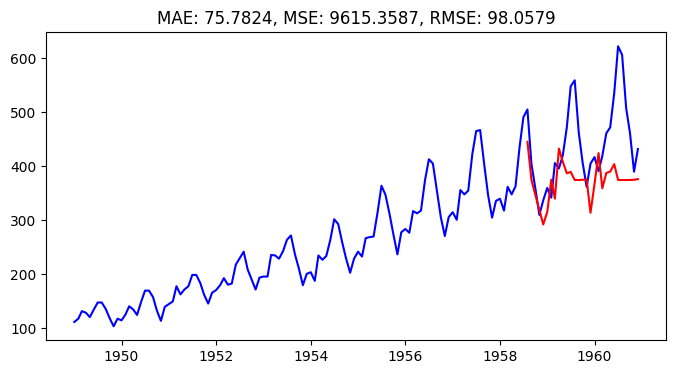

In [153]:
boost(df)

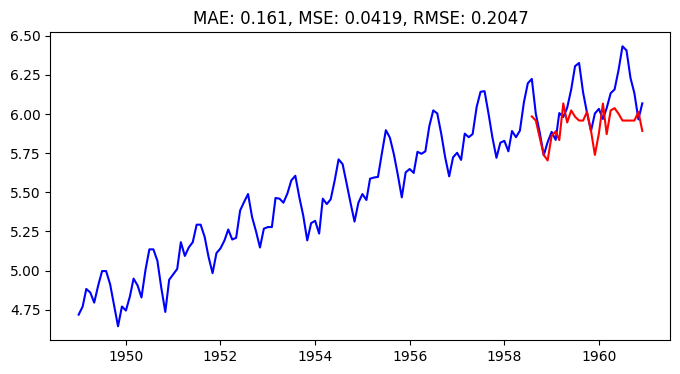

In [154]:
boost(logdf)

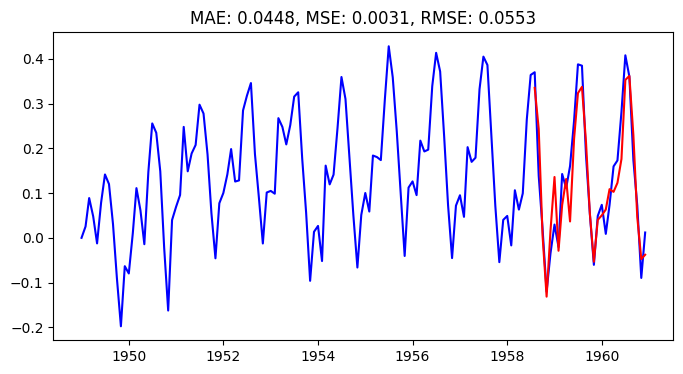

In [155]:
boost(log_expo_no_ma)

It seems that gradient boosting better works if we remove moving average, log-transform data and add exponential decay.